# **Bài toán dự đoán hành động di chuyển của người**

### Bộ dữ liệu: WISDM v1.1
### Dạng bài toán Classification
### Yêu cầu dự đoán: loại hành động của người dựa trên trục X Y Z

### Mô tả đặc trưng:
+ __User ID__: Số thứ tự của người tham gia khảo sát (tổng 36 người), Kiểu dữ liệu: Số
+ __Activity__: Loại hành động, Kiểu dữ liệu: Chữ
+ __Timestamp__: Mốc thời gian của hành động, Kiểu dữ liệu: Số
+ **X_axis, Y_axis, Z_axis**: Điểm trong không gian 3 chiều, Kiểu dữ liệu: Số

## **Khảo sát dữ liệu**:

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [1]:
column = ['User ID', 'Activity', 'Timestamp', 'X_axis', 'Y_axis', 'Z_axis']
dfs = pd.read_csv("WISDM_ar_v1.1_raw.txt",header=None,names=column)
dfs.Z_axis.replace(regex=True, inplace=True, to_replace=r';', value='')
dfs['Z_axis'] = dfs.Z_axis.astype(np.float64)
dfs.dropna(axis=0, how='any', inplace=True)
dfs.head(5)


,User ID,Activity,Timestamp,X_axis,Y_axis,Z_axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


### Vẽ đồ thị khảo sát số lượng dữ liệu của từng người:

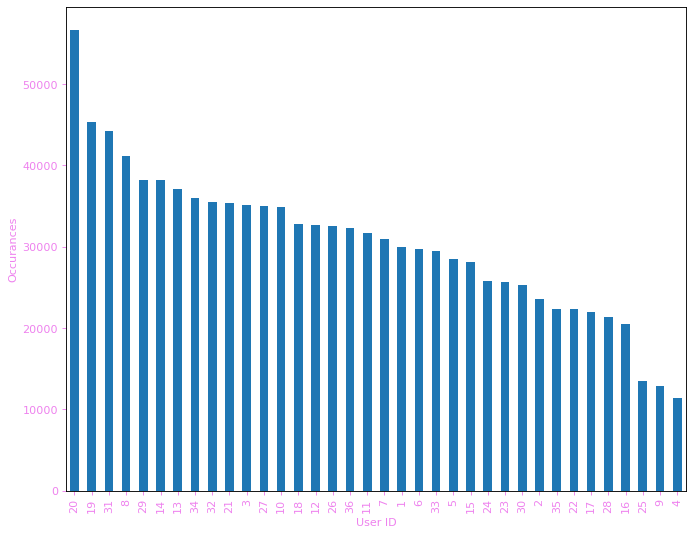

In [2]:
plt.figure(figsize=(10,8), dpi=80, edgecolor='black')
dfs['User ID'].value_counts().plot.bar()
xlabel = plt.xlabel("User ID")
ylabel = plt.ylabel("Occurances")
xlabel.set_color("violet")
ylabel.set_color("violet")

plt.tick_params(axis='x', colors='violet')
plt.tick_params(axis='y', colors='violet')

### Vẽ đồ thị khảo sát số lượng dữ liệu của từng hành động:

* Ghi chú [1]: Lượng điểm dữ liệu cho hành động đi bộ (Walking) và chạy (Jogging) nhiều gấp 3 lần so với hành độn lên cầu thang và xuống lầu, điều này có thể ảnh hưởng kết quả train ở gian đoạn sau.

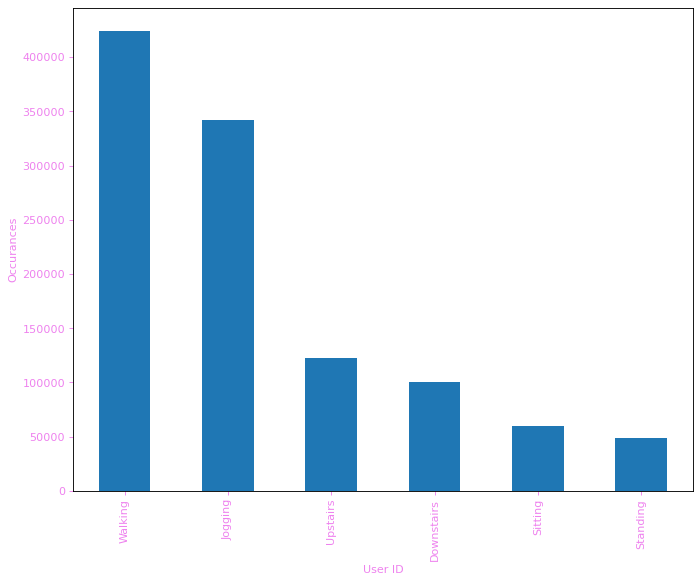

In [3]:
plt.figure(figsize=(10,8), dpi=80, edgecolor='black')
dfs['Activity'].value_counts().plot.bar()
xlabel = plt.xlabel("User ID")
ylabel = plt.ylabel("Occurances")
xlabel.set_color("violet")
ylabel.set_color("violet")

plt.tick_params(axis='x', colors='violet')
plt.tick_params(axis='y', colors='violet')

In [4]:
corr = dfs.corr()
corr['Z_axis']

User ID     -0.004503
Timestamp    0.033627
X_axis       0.067995
Y_axis       0.017384
Z_axis       1.000000
Name: Z_axis, dtype: float64

### Chia dữ liệu cho train và test:

- Chọn dữ liệu từ 25 người trên tổng 36, tỉ lệ chọn là 70%

In [5]:
# Sample size of 36 people, select 25 for training and 11 for testing
df_trains = dfs[dfs['User ID'] <= 25]
df_tests = dfs[dfs['User ID'] > 25]


### Chuẩn hoá dữ liệu bằng cách scale dữ liệu:

- Vì dữ liệu số của X Y Z có độ chênh lệch cao và có outlier(dữ liệu thật) nên robustscaler sẽ được sữ dụng đễ scale dữ liệu thay vì minmax scaling

In [6]:
from sklearn.preprocessing import RobustScaler
scale_columns = ['X_axis','Y_axis','Z_axis']

scaler = RobustScaler()

# Scale the data number
scaler = scaler.fit(df_trains[scale_columns])

df_trains.loc[:,scale_columns] = scaler.transform(
    df_trains[scale_columns].to_numpy()
)

df_tests.loc[:,scale_columns] = scaler.transform(
    df_tests[scale_columns].to_numpy()
)



c:\Users\fisha\anaconda3\envs\directML_test\lib\site-packages\pandas\core\indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
c:\Users\fisha\anaconda3\envs\directML_test\lib\site-packages\pandas\core\indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


### Chia dữ liệu thành X Y set:

- Từ dữ liệu gốc, ta chọn cột: X_axis, Y_axis, Z_axis cho X List và Nhẵn "Activity" cho cột Y

In [7]:
from scipy import stats
import numpy as np

# split the dataset into "time steps" or batches and Y data to individual arrays
def create_dataset(X_ins, Y_ins, time_step=1, step=1):
    Xs, Ys = [], []
    for i in range(0, len(X_ins) - time_step, step):
        v = X_ins.iloc[i:(i + time_step)].values
        labels = Y_ins.iloc[i:(i + time_step)]
        Xs.append(v)
        Ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(Ys).reshape(-1, 1)

In [8]:
# 200 movement sample per steps as anything larger than 500 takes too long to train
time_steps = 200
step = 40

X_trains, Y_trains = create_dataset(
    df_trains.drop(columns=['User ID','Timestamp','Activity']), 
    df_trains['Activity'],
    time_steps,
    step
)
X_tests, Y_tests = create_dataset(
    df_tests.drop(columns=['User ID','Timestamp','Activity']), 
    df_tests['Activity'],
    time_steps,
    step
)
print(f'Train shape: X:{X_trains.shape} Y:{Y_trains.shape}')
print(f'Train shape: X:{X_tests.shape} Y:{Y_tests.shape}')

Train shape: X:(18643, 200, 3) Y:(18643, 1)
Train shape: X:(8803, 200, 3) Y:(8803, 1)


### Xử lý nhãn:

- Vì nhãn là chữ và không có độ ưu tiên(ví dụ như xếp loại học lực của học sinh), nên ta sẽ dùng dummy/onehotencoder để encode thành từng cột khác nhau.

In [9]:
# Transform categories into columns
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder = encoder.fit(Y_trains)

Y_trains = encoder.fit_transform(Y_trains)
Y_tests = encoder.fit_transform(Y_tests)

# print(f'One-Hot encoded Y trains: {Y_trains}')
print(f'Y train shape: {Y_trains.shape}')
print(f'Y train shape: {Y_tests.shape}')


Y train shape: (18643, 6)
Y train shape: (8803, 6)


## **Tạo model và train model**:


### Tạo model BiLSTM (Bidirectional LSTM):

Giải thích model:
+ Model dùng 1 lớp BiLSTM kết nối với 1 lớp dropout dùng cho chính quy hoá dữ liệu (Regularization)
+ Sau đó model kết nối với 1 lớp Dense có sử dụng max_norm(3) cho chính quy hoá dữ liệu
+ Tầng output sử dụng phương pháp kích hoạt là softmax phổ biến cho bài toán phân loại

In [10]:
from tensorflow.keras import models, layers, utils, activations, preprocessing, losses, metrics, constraints
model = models.Sequential()
model.add(layers.Input(shape=(X_trains.shape[1], X_trains.shape[2])))
model.add(
    layers.Bidirectional(
        layers.LSTM(
            units=64,
            input_shape=[X_trains.shape[1], X_trains.shape[2]]
        )
    )
)
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(units=64, kernel_constraint=constraints.max_norm(3),activation='relu'),)
model.add(layers.Dense(Y_trains.shape[1], activation='softmax'))

model.build()
model.summary()
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 128)               34816     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)  

+ Ghi chú: vì bộ dữ liệu có nhiều điểm dữ liệu nên thời gian huấn luyện model lâu: 2 tiếng và 30p sử dụng card đồ hoạ RX 5700(Non-XT)

In [11]:
histories = model.fit(
    X_trains, Y_trains,
    epochs=30,
    batch_size=30,
    validation_split=0.30,
    shuffle=False
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 13050 samples, validate on 5593 samples
Epoch 1/30
13050/13050 [==============================] - 292s 22ms/sample - loss: 1.4229 - acc: 0.5130 - val_loss: 1.2170 - val_acc: 0.6081
Epoch 2/30
13050/13050 [==============================] - 293s 22ms/sample - loss: 1.1662 - acc: 0.5998 - val_loss: 1.0958 - val_acc: 0.6399
Epoch 3/30
13050/13050 [==============================] - 299s 23ms/sample - loss: 0.9875 - acc: 0.6803 - val_loss: 0.8761 - val_acc: 0.7264
Epoch 4/30
13050/13050 [==============================] - 301s 23ms/sample - loss: 0.8150 - acc: 0.7141 - val_loss: 0.8433 - val_acc: 0.7399
Epoch 5/30
13050/13050 [==============================] - 294s 22ms/sample - loss: 0.7441 - acc: 0.7381 - val_loss: 0.8300 - val_acc: 0.7143
Epoch 6/30
13050/13050 [==============================] - 287s 22ms/sample - loss: 0.6737 - acc: 0.7526 - val_loss: 0.7849 - val_acc: 0.7449
Epoch 7/30


In [12]:
evaluation_tests = model.evaluate(X_tests, Y_tests)
y_predicts = model.predict(X_tests)

8803/8803 [==============================] - 58s 7ms/sample - loss: 0.8624 - acc: 0.7731


## **Khảo sát dữ liệu**:

### Đồ thị khảo sát độ chính xác của model và mất mát theo từng epoch:

+ Cả 2 đồ thị cho thấy sự cải thiện của độ chính xác ở set validation dừng lại ở mức 10 epochs và dao động 10% cho độ chính xác và loss dao động ở mức 0.2%

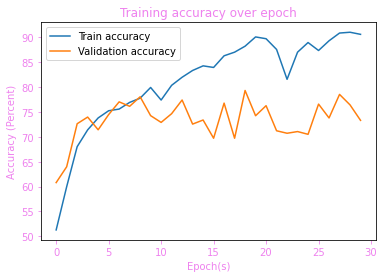

In [20]:
hist = pd.DataFrame(histories.history)
hist['epoch'] = histories.epoch
plt.figure()
plt.xlabel('Epoch(s)').set_color('violet')
plt.ylabel('Accuracy (Percent)').set_color('violet')

plt.tick_params(axis='x', colors='violet')
plt.tick_params(axis='y', colors='violet')

plt.plot(hist['epoch'], hist['acc'].multiply(100), label ='Train accuracy')
plt.plot(hist['epoch'], hist['val_acc'].multiply(100), label ='Validation accuracy')
plt.title('Training accuracy over epoch').set_color('violet')
plt.legend()
plt.show()

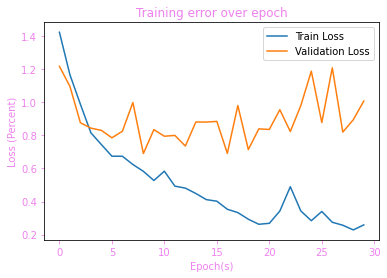

In [21]:
hist = pd.DataFrame(histories.history)
hist['epoch'] = histories.epoch
plt.figure()
plt.xlabel('Epoch(s)').set_color('violet')
plt.ylabel('Loss (Percent)').set_color('violet')

plt.tick_params(axis='x', colors='violet')
plt.tick_params(axis='y', colors='violet')

plt.plot(hist['epoch'], hist['loss'], label ='Train Loss')
plt.plot(hist['epoch'], hist['val_loss'], label ='Validation Loss')
plt.title('Training error over epoch').set_color('violet')
plt.legend()
plt.show()

In [15]:
Y_tests = encoder.inverse_transform(Y_tests)
y_predicts = encoder.inverse_transform(y_predicts)
print(Y_tests)
print(y_predicts)

[['Jogging']
 ['Jogging']
 ['Jogging']
 ...
 ['Standing']
 ['Standing']
 ['Standing']]
[['Jogging']
 ['Jogging']
 ['Jogging']
 ...
 ['Upstairs']
 ['Downstairs']
 ['Upstairs']]


### Phân tích kết quả dự đoán:

Phân tích cho thấy:
+ Độ chính xác kết quả dự đoán của kiểu "Đi lên lầu" (upstairs) và "Đi xuống lầu" (downstair) thấp
+ Trong khi đó độ chính xác của các hành động còn lại có độ chính xác cao.

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(Y_tests, y_predicts))

              precision    recall  f1-score   support

  Downstairs       0.54      0.31      0.40       909
     Jogging       0.90      0.89      0.89      2587
     Sitting       0.85      0.80      0.83       501
    Standing       0.68      0.73      0.71       444
    Upstairs       0.46      0.57      0.51       971
     Walking       0.83      0.87      0.85      3391

    accuracy                           0.77      8803
   macro avg       0.71      0.70      0.70      8803
weighted avg       0.77      0.77      0.77      8803



### Vẽ đồ thị ma trận confusion:

Đồ thị cho thấy:
+ Model bị nhầm lẫn nhiều giữa hành động đi lên lầu xuống lầu với đi bộ
+ Trong khi đó model dự đoán tốt cho hành động walking và jogging

<function matplotlib.pyplot.show(close=None, block=None)>

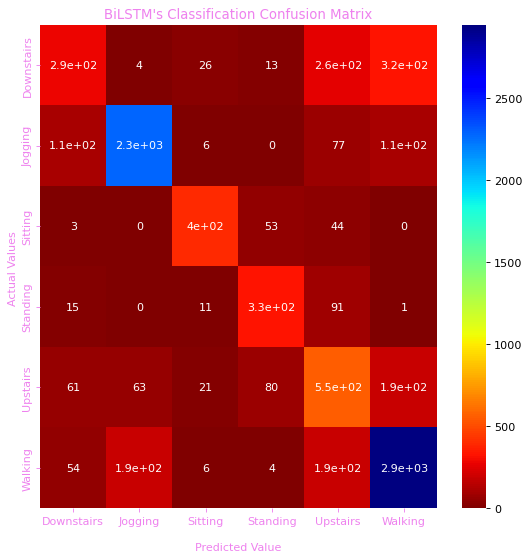

In [17]:

conf_matrix = confusion_matrix(Y_tests, y_predicts)
plt.figure(figsize=(8,8), dpi=80)
ax = sns.heatmap(conf_matrix, annot=True, cmap='jet_r')
ax.set_title('BiLSTM\'s Classification Confusion Matrix').set_color('violet')
ax.set_xlabel('\nPredicted Value').set_color('violet')
ax.set_ylabel('Actual Values ').set_color('violet')

ax.set_xticklabels(['Downstairs','Jogging','Sitting','Standing','Upstairs','Walking'])
ax.set_yticklabels(['Downstairs','Jogging','Sitting','Standing','Upstairs','Walking'])

plt.tick_params(axis='x', colors='violet')
plt.tick_params(axis='y', colors='violet')
plt.show

### **Kết luận**: Model thể hiện tốt cho hành động jogging và walking với sai sót ít trong khi đó model bị nhầm lẫn nhiều ở hạnh động downstairs và upstairs.

Lý giải chung: 
+ Có thể vì điểm dữ liệu cho 2 hành động trên thấp hoặc là dữ liệu có nhiều điểm giống nhau nên model thể hiện kém. 
+ Trong khi đó mặc dù có ít dữ liệu, hành động dứng và ngồi khác nhau hẳng
+ Và hành động đi bộ cũng như chạy bộ có nhiều điểm giống nhau nhưng do có nhiều điểm dữ liệu nên model có thể nhận diện được các điểm khác nhau rõ rệt